# PyMC3 routine

In [2]:
%load_ext autoreload 
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context="paper" , style ="whitegrid",rc={"figure.facecolor":"white"})

import statsmodels.api as sm
import pymc3 as pm
import theano
import theano.tensor as tt
import pickle
import datetime

import warnings
warnings.filterwarnings('ignore')

# data preparation

In [4]:
df = sm.datasets.anes96.load_pandas().data
exog = ["TVnews","selfLR","PID","educ"]
endog = "vote"

# prepare function

In [5]:
EPS = np.finfo(float).eps
def logiFunc(x):
    v = 1./(1. + tt.exp(-x) )
    v = tt.clip(v,EPS,1-EPS)
    return(v)
 
def pred(X,w):
    linear = tt.sum(w*X,axis=1)
    y =  logiFunc(linear)  
    return(y)

def logLikelihood(t,X,w):
    y = pred(X,w) 
    ll = t * tt.log(y) + (1-t)*tt.log(1-y) 
    ll = tt.sum(ll)
    return(ll)

# sampling

In [6]:
# set preparation 
m = len(exog)
x = df[exog].values
y = df[endog].values
x_shared = theano.shared(x)

# sampling parameters 
nIter = 1000
nBurn = 500
chains = 2
cores = 2
randomSeed = 1123890


In [7]:
# save result using pickle.
time = datetime.datetime.now().strftime("%Y%m%d%H%M")
savePath = "./model_%s.db" % time 

with pm.Model() as model:
    coeff = pm.Normal('beta', mu=0, sigma=100,shape=m)
    pm.DensityDist('likelihood',logLikelihood , observed=dict(t=y,X=x,w=coeff))
    # fit the model
    trace = pm.sample(draws=nIter,
                      tune=nBurn, 
                      chains=chains,
                      cores=cores,
                      target_accept=0.8,
                      random_seed=randomSeed)

with open(savePath, 'wb') as buff:
    pickle.dump({'model': model, 'trace': trace}, buff)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:11<00:00, 258.75draws/s]
The acceptance probability does not match the target. It is 0.8807500048756219, but should be close to 0.8. Try to increase the number of tuning steps.


#  load data

In [8]:
# reuse the result. 
with open(savePath, 'rb') as buff:
    data = pickle.load(buff)
modelRec = data['model']
traceRec = data['trace']
alpha = 0.95 # for credible interval

# pm.model_to_graphviz(modelRec)

In [9]:
dfSum = pm.summary(traceRec,credible_interval=alpha,stat_funcs={"median":np.median}).round(3)
dfSum

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,median
beta[0],-0.111,0.036,-0.184,-0.045,0.001,0.001,1625.0,1625.0,1620.0,1117.0,1.0,-0.110
beta[1],-0.308,0.067,-0.433,-0.174,0.002,0.002,974.0,929.0,973.0,1073.0,1.0,-0.310
beta[2],1.170,0.071,1.037,1.319,0.002,0.002,1092.0,1092.0,1092.0,944.0,1.0,1.166
beta[3],-0.447,0.053,-0.555,-0.344,0.002,0.001,1190.0,1152.0,1225.0,974.0,1.0,-0.446


0


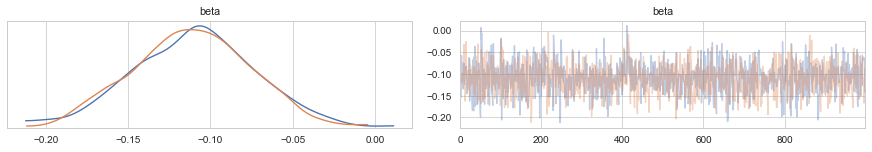

1


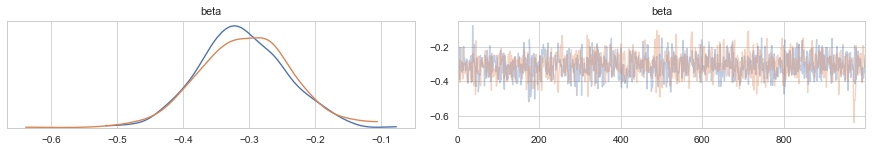

2


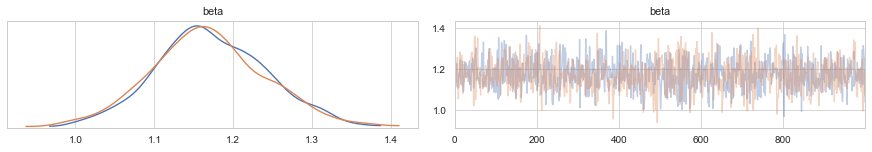

In [10]:
for i in range(3):
    print("%d" %(i))
    pm.traceplot(traceRec,var_names="beta",coords={"beta_dim_0":[i]})
    plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2564e7b8>,
      dtype=object)

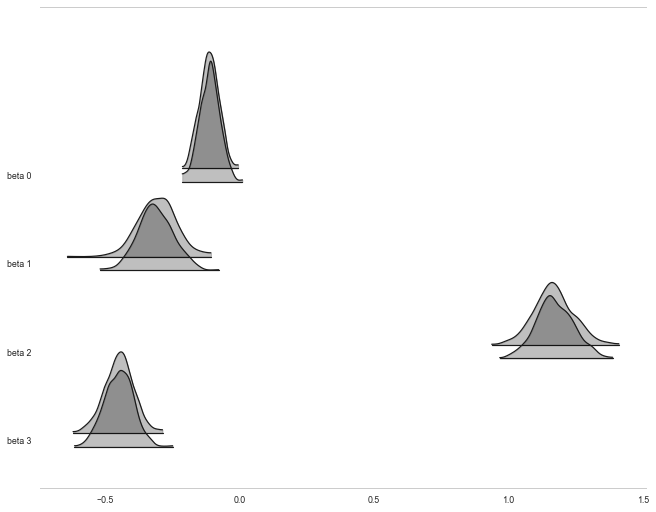

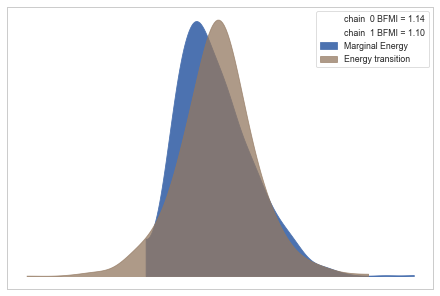

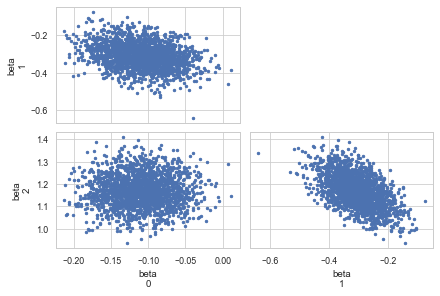

In [11]:
pm.plot_forest(traceRec,
               kind='ridgeplot',
               var_names=['beta'],
               combined=False,
               ridgeplot_overlap=4,
               ridgeplot_alpha=.25,
               colors='black',
               figsize=(9, 7))
pm.energyplot(traceRec)
pm.pairplot(traceRec, var_names=["beta"],coords={"beta_dim_0":[0,1,2]}, divergences=True,)

# Compare model 

In [12]:
def loadData(path):
    with open(path, 'rb') as buff:
        data = pickle.load(buff)
    model = data['model']
    trace = data['trace']
    return(model,trace)

def getModelDict(paths,names):
    dic_ = {}
    for path, name in zip(paths,names):
        model,trace = loadData(path)
        dic_[name] = trace
    return(dic_)


In [14]:
models = ["./model_202002061612.db","./model_202002061618.db"]
names  = ["model1","model2"]
dic = getModelDict(models,names)
df_comp_WAIC = pm.compare(dic)

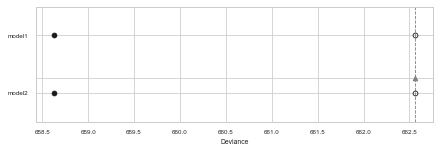

In [16]:
pm.compareplot(df_comp_WAIC)